In [12]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('weather.csv', sep=',')
len(df)

# Ci sono 178396 istanze nel dataset

178396

In [14]:
if df.isnull().sum().all() == 0:
    print("No missing values")
else:
    print("There are missing values")

# Non ci sono valori mancanti

No missing values


<Axes: >

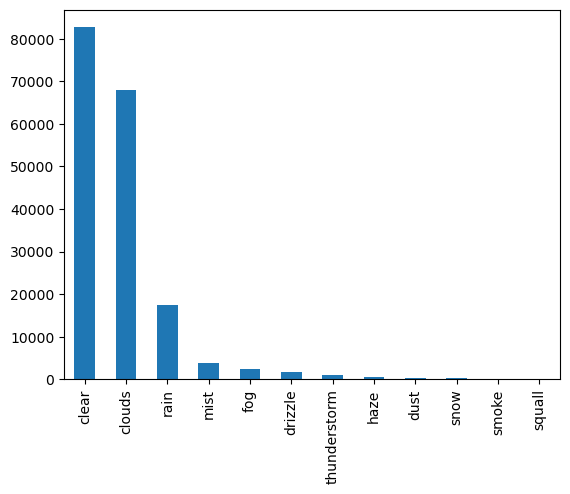

In [18]:
df['weather_main'].value_counts().plot(kind='bar')

# No, il dataset non è bilanciato rispetto alla classe da predire

In [25]:
df.loc[(df['humidity'] == 0) | (df['pressure'] == 0)].count()
df = df.drop(df[(df['humidity'] == 0) | (df['pressure'] == 0)].index)

# Ci sono 65 istanze che presentano valori di umidità o pressione uguali a 0


178331

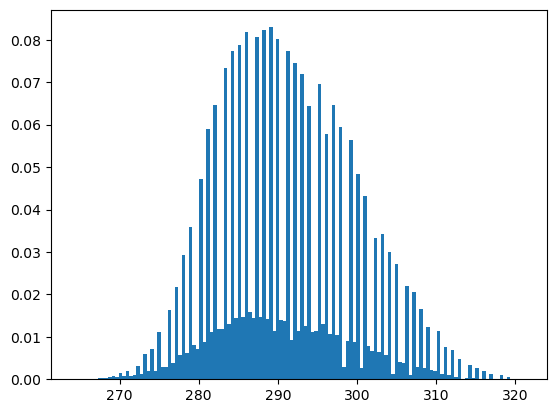

In [31]:
plt.hist(df['temp_max'], bins = 'auto', density=True)
plt.show()

# L'andamento della distribuzione è simile ad una gaussiana

<Axes: >

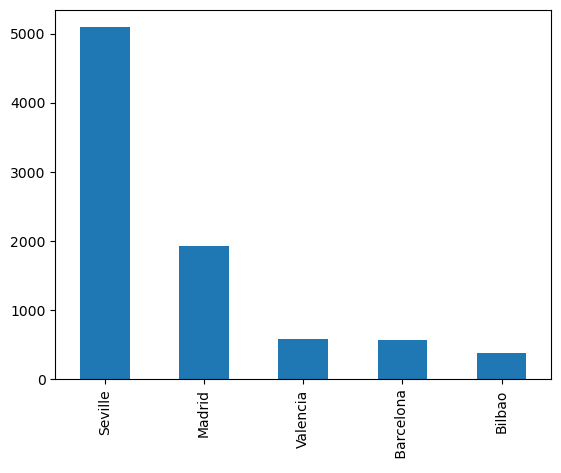

In [32]:
df.loc[df['temp_max'] > df['temp_max'].quantile(0.95)]['city_name'].value_counts().plot(kind='bar')

# Le città non sono equamente rappresentate in questa fascia di temperatura, Siviglia è la città con più istanze

In [34]:
df.loc[df['snow_3h'] != 0]['temp'].mean() - 273.15

# La temperatura media è di 2.74 gradi Celsius, quindi prossima alla temperatura di congelamento

2.7434239232209734

In [40]:
average_snow_temp = df.loc[df['snow_3h'] != 0]['temp_max'].mean() - df.loc[df['snow_3h'] != 0]['temp_min'].mean()
average_hot_day_temp = df.loc[df['temp_max'] > df['temp_max'].quantile(0.95)]["temp_max"].mean() - df.loc[df['temp_max'] > df['temp_max'].quantile(0.95)]["temp_min"].mean()

print("L'escursione termica nei giorni di neve è di " + str(average_snow_temp) + " gradi Celsius")
print("L'escursione termica nei giorni caldi è di " + str(average_hot_day_temp) + " gradi Celsius")

# L'escursione termica nei giorni di neve è di 0.0 gradi Celsius
# L'escursione termica nei giorni caldi è di 7.852272833723646 gradi Celsius

L'escursione termica nei giorni di neve è di 0.0 gradi Celsius
L'escursione termica nei giorni caldi è di 7.852272833723646 gradi Celsius


In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(name, model, X_train, X_test, y_train, y_test, metric):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    m_test = metric(y_test, y_pred_test)
    m_train = metric(y_train, y_pred_train)

    # Print the results
    print(name + " - Test: " + str(m_test))
    print(name + " - Train: " + str(m_train))

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

Decision Tree - Test: 0.638411214953271
Decision Tree - Train: 0.9836018296737189


/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression - Test: 0.4814766355140187
Logistic Regression - Train: 0.48288486033116773


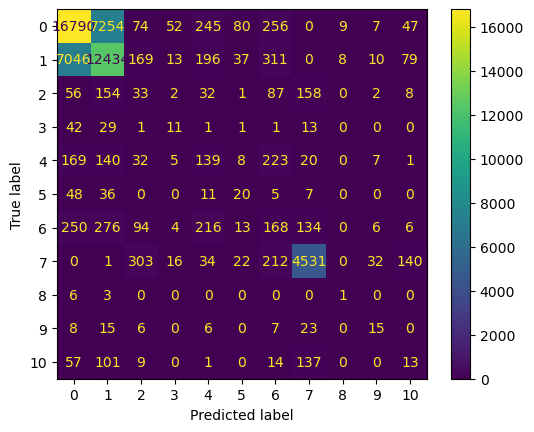

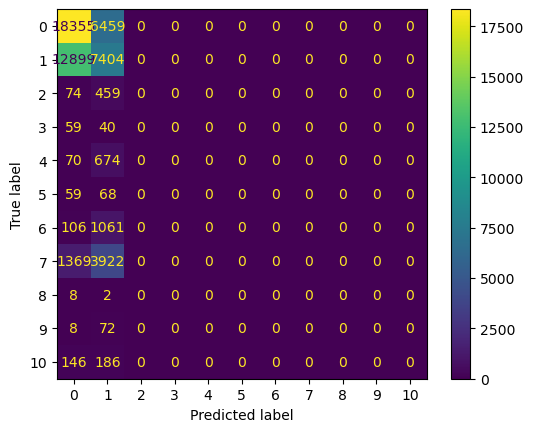

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Create a copy of the dataframe
df1 = df.copy()

# Drop the columns that are not useful for the analysis
features = ["dt_iso", "city_name", "weather_description", "weather_icon", "weather_id", "clouds_all"]
df1 = df1.drop(features, axis=1)

# Perform ordinal encoding on the weather_main column
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df1["weather_main"] = enc.fit_transform(df1[["weather_main"]])


# Split the dataset
X = df1.drop('weather_main', axis=1)
y = df1['weather_main']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier()
evaluate_model("Decision Tree", clf, X_train, X_test, y_train, y_test, accuracy_score)

# Train a Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='multinomial', solver='saga')

evaluate_model("Logistic Regression", clf, X_train, X_test, y_train, y_test, accuracy_score)

# Il decision tree non ha una accuratezza molto alta, la logistic regression invece ha una accuratezza nettamente inferiore, dovuta probabilmente al fatto che il dataset non è bilanciato
# Infatti le combinazioni meno frequenti non vengono predette praticamente mai dalla logistic regression

In [65]:
# Repeat the same analysis using 10-fold cross validation
from sklearn.model_selection import cross_val_score

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print("Decision Tree - Cross Validation: " + str(scores.mean()))

# Train a Logistic Regression Classifier
#clf = LogisticRegression(multi_class='multinomial', solver='saga')         # Non funziona, non converge e non so perché
#scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')

# Decision Tree - Cross Validation: 0.5195674171306903

/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Decision Tree - Cross Validation: 0.5205038640525045


Decision Tree - Test: 0.622803738317757
Decision Tree - Train: 0.983641883826934


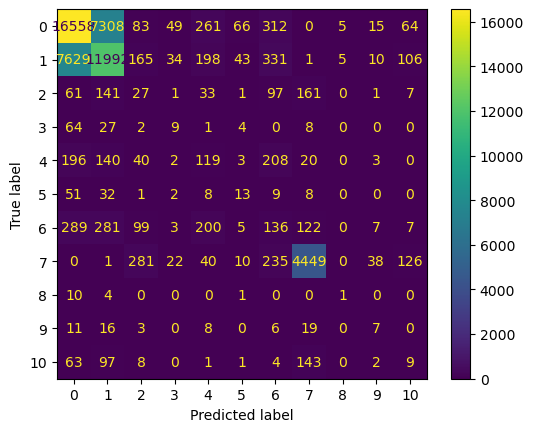

In [73]:
# use the Normalizer to normalize the data
from sklearn.preprocessing import Normalizer

df2 = df.copy()

# Drop the columns that are not useful for the analysis
features = ["dt_iso", "city_name", "weather_description", "weather_icon", "weather_id", "clouds_all"]
df2 = df2.drop(features, axis=1)

# Perform ordinal encoding on the weather_main column
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df2["weather_main"] = enc.fit_transform(df2[["weather_main"]])

# Normalize the data
X = df2.drop('weather_main', axis=1)
y = df2['weather_main']

X_normalized = Normalizer().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier()
evaluate_model("Decision Tree", clf, X_train, X_test, y_train, y_test, accuracy_score)

# Normalizzando i dati l'accuratezza non migliora

Pipeline - Test: 0.6365233644859813
Pipeline - Train: 0.9835858080124328


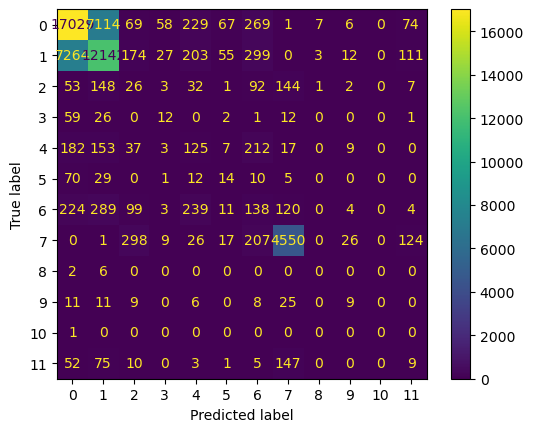

In [82]:
# Create a pipeline with PCA and the Normalizer to add 5 components to the dataset
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
normalizer = Normalizer()

# Create the pipeline. The pipeline should normalize the data and then add the 5 compnents found by PCA to the original dataset
combined = FeatureUnion([("pca", pca), ("original", FunctionTransformer(lambda x: x)), ("normalizer", normalizer)])

# Create the pipeline
pipe = Pipeline([("combined", combined), ("clf", DecisionTreeClassifier())])

# Split the dataset
X = df2.drop('weather_main', axis=1)
y = df2['weather_main']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train the model
evaluate_model("Pipeline", pipe, X_train, X_test, y_train, y_test, accuracy_score)

# La pipeline non migliora l'accuratezza


In [84]:
# Add the grid search to the pipeline
from sklearn.model_selection import GridSearchCV

parameters = {
    'clf__criterion': ['gini', 'entropy'],
    "combined__pca__n_components": [2, 3, 4]
}

pca = PCA()
normalizer = Normalizer()

# Create the pipeline. The pipeline should normalize the data and then add the 5 compnents found by PCA to the original dataset
combined = FeatureUnion([("pca", pca), ("original", FunctionTransformer(lambda x: x)), ("normalizer", normalizer)])

# Create the pipeline
pipe = Pipeline([("combined", combined), ("clf", DecisionTreeClassifier())])

# Split the dataset
X = df2.drop('weather_main', axis=1)
y = df2['weather_main']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train the model with grid search
clf = GridSearchCV(pipe, parameters, scoring='accuracy')
clf.fit(X_train, y_train)

# Print the best parameters
print(clf.best_params_)



/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'clf__criterion': 'entropy', 'combined__pca__n_components': 4}
